In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as px
import duckdb

In [2]:
file = 'media_prediction.csv'
df = pd.read_csv(file)
print(df.shape)
df.head()

(60428, 40)


,food_category,food_department,food_family,store_sales(in millions),store_cost(in millions),unit_sales(in millions),promotion_name,sales_country,marital_status,gender,...,grocery_sqft,frozen_sqft,meat_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,media_type,cost
0,Breakfast Foods,Frozen Foods,Food,7.36,2.7232,4.0,Bag Stuffers,USA,M,F,...,18670.0,5415.0,3610.0,1.0,1.0,1.0,1.0,1.0,"Daily Paper, Radio",126.62
1,Breakfast Foods,Frozen Foods,Food,5.52,2.5944,3.0,Cash Register Lottery,USA,M,M,...,18670.0,5415.0,3610.0,1.0,1.0,1.0,1.0,1.0,"Daily Paper, Radio",59.86
2,Breakfast Foods,Frozen Foods,Food,3.68,1.3616,2.0,High Roller Savings,USA,S,F,...,18670.0,5415.0,3610.0,1.0,1.0,1.0,1.0,1.0,"Daily Paper, Radio",84.16
3,Breakfast Foods,Frozen Foods,Food,3.68,1.1776,2.0,Cash Register Lottery,USA,M,F,...,18670.0,5415.0,3610.0,1.0,1.0,1.0,1.0,1.0,In-Store Coupon,95.78
4,Breakfast Foods,Frozen Foods,Food,4.08,1.4280,3.0,Double Down Sale,USA,M,M,...,18670.0,5415.0,3610.0,1.0,1.0,1.0,1.0,1.0,Radio,50.79


In [3]:
def dfsql(query):
    return duckdb.query(query).df()

In [4]:
df.info() # non-null

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60428 entries, 0 to 60427
Data columns (total 40 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   food_category               60428 non-null  object 
 1   food_department             60428 non-null  object 
 2   food_family                 60428 non-null  object 
 3   store_sales(in millions)    60428 non-null  float64
 4   store_cost(in millions)     60428 non-null  float64
 5   unit_sales(in millions)     60428 non-null  float64
 6   promotion_name              60428 non-null  object 
 7   sales_country               60428 non-null  object 
 8   marital_status              60428 non-null  object 
 9   gender                      60428 non-null  object 
 10  total_children              60428 non-null  float64
 11  education                   60428 non-null  object 
 12  member_card                 60428 non-null  object 
 13  occupation                  604

In [5]:
df.duplicated().sum() # 중복 레코드 x

0

In [6]:
df[df['cost'] == 0]

,food_category,food_department,food_family,store_sales(in millions),store_cost(in millions),unit_sales(in millions),promotion_name,sales_country,marital_status,gender,...,grocery_sqft,frozen_sqft,meat_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,media_type,cost


In [7]:
(df['avg_cars_at home(approx)'] == df['avg_cars_at home(approx).1']).sum() # 이름이 비슷하다. 알고보니 중복열

60428

In [8]:
del df['avg_cars_at home(approx).1']

In [9]:
df.loc[0] # 컬럼은 상품정보, 프로모션 정보, 고객 정보, 지점 정보 등이 섞여있다.

food_category                   Breakfast Foods
food_department                    Frozen Foods
food_family                                Food
store_sales(in millions)                   7.36
store_cost(in millions)                  2.7232
unit_sales(in millions)                     4.0
promotion_name                     Bag Stuffers
sales_country                               USA
marital_status                                M
gender                                        F
total_children                              1.0
education                   Partial High School
member_card                              Normal
occupation                       Skilled Manual
houseowner                                    Y
avg_cars_at home(approx)                    1.0
avg. yearly_income                  $10K - $30K
num_children_at_home                        1.0
brand_name                           Carrington
SRP                                        1.84
gross_weight                            

<Axes: >

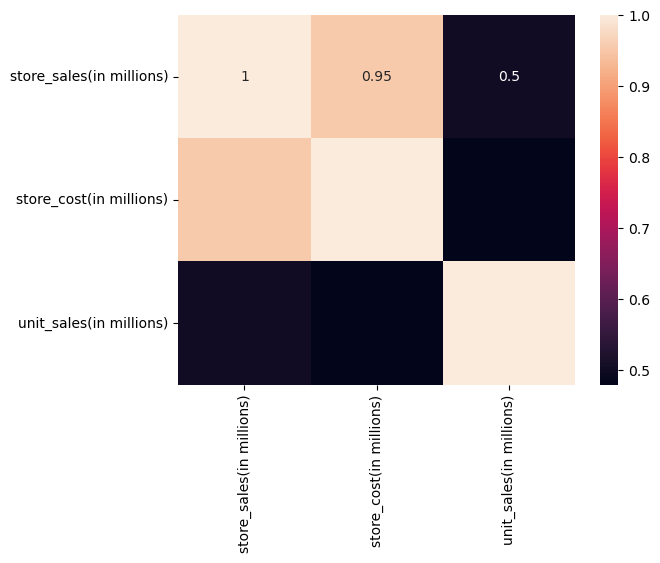

In [10]:
corr=df[df.columns[[3,4,5]]].corr()
sns.heatmap(corr, annot=True) # store_sales, store_cost 아주 강한 상관관계가 보인다.

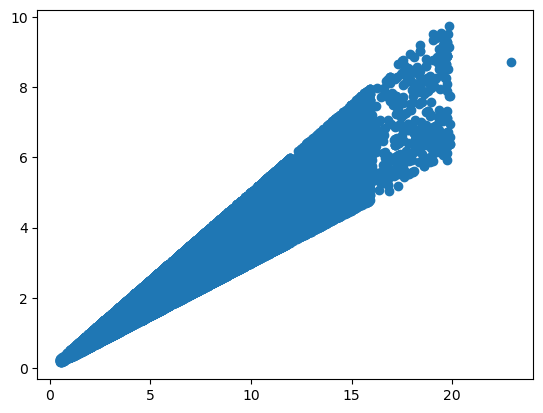

In [11]:
plt.scatter(df['store_sales(in millions)'], df['store_cost(in millions)'])
# 각각, 재고의 실제 가격과 재고의 판매가격의 총합인것으로 추측

In [12]:
df['unit_sales(in millions)'].value_counts() # 그렇다면 unit_sales(in millions)은 상품별 지금까지 판매액의 누적 합계인것 같다.

unit_sales(in millions)
3.0    27482
4.0    16581
2.0    13417
5.0     2058
1.0      864
6.0       26
Name: count, dtype: int64

In [13]:
for l in df.columns:
    print(f'{l} : {df[l].nunique()}') # sqft의 nunique가 20으로 통일된다. 20개 지점에서 수집된 데이터인가보다

food_category : 45
food_department : 22
food_family : 3
store_sales(in millions) : 1033
store_cost(in millions) : 9919
unit_sales(in millions) : 6
promotion_name : 49
sales_country : 3
marital_status : 2
gender : 2
total_children : 6
education : 5
member_card : 4
occupation : 5
houseowner : 2
avg_cars_at home(approx) : 5
avg. yearly_income : 8
num_children_at_home : 6
brand_name : 111
SRP : 315
gross_weight : 376
net_weight : 332
recyclable_package : 2
low_fat : 2
units_per_case : 36
store_type : 5
store_city : 19
store_state : 10
store_sqft : 20
grocery_sqft : 20
frozen_sqft : 20
meat_sqft : 20
coffee_bar : 2
video_store : 2
salad_bar : 2
prepared_food : 2
florist : 2
media_type : 13
cost : 328


In [14]:
key = df['store_sqft'].unique()
id_mapping = {}

for i, value in enumerate(key):
    id_mapping[value] = i % 20

In [15]:
df['store_id'] = df['store_sqft'].map(id_mapping) # store_id 열 생성

In [16]:
for i in range(len(df['store_id'].unique())):   # store_id 별로 store_type이 일치하는걸 봐선 지점 20개 맞는듯
    print(df[df['store_id'] == i]['store_type'].nunique() == 1, end=' ')

True True True True True True True True True True True True True True True True True True True True 

In [17]:
media = df['media_type'].unique()

## Cost가 Promotion의 단발성 비용일 때 

<Axes: >

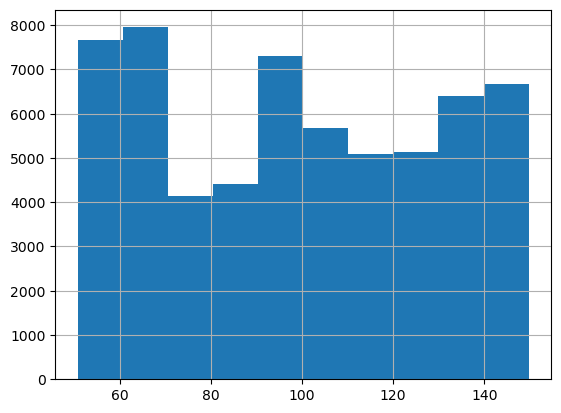

In [18]:
df['cost'].hist() # TV, Radio 등 미디어로 마케팅하는데 140 달러밖에 들리가 없다. 단위가 생략되었나?

In [19]:
media_avg_cost = dfsql('''
                            select media_type, avg(cost) as avg_cost 
                            from df group by media_type order by avg_cost desc
                        ''')
# avg(cost) = media_type에 대한 평균 cost ( cost가 각 promotion의 단발성 비용이고,
                                #       store_sales와 다르게 (in million) 처럼 단위가 생략되었다는 가정을 한다면 )

In [20]:
media_avg_cost # cost가 행사의 단발성 비용일때 전단지가 TV 광고보다 비싸다는게 이해가 안된다.
                  # Cost 열은 그 고객의 Acquisition Cost로 추정된 금액인 것 같다. (프로모션 지출 비용 / 프로모션에 반응한 고객 수)

,media_type,avg_cost
0,Cash Register Handout,114.935647
1,Street Handout,108.685326
2,"Sunday Paper, Radio",105.687131
3,Product Attachment,104.336822
4,Bulk Mail,104.087744
5,Sunday Paper,101.230712
6,In-Store Coupon,99.993493
7,"Daily Paper, Radio",97.971450
8,Radio,96.703759
9,"Sunday Paper, Radio, TV",90.965377


## Cost가 고객 한명당 획득 금액일 경우

In [21]:
media_sum_cost = dfsql('''
                            select media_type, avg(cost)*count(*) as sum_cost 
                            from df group by media_type order by sum_cost desc
                        ''')

In [22]:
media_sum_cost # media_type 별로 지금까지 지출 금액 # 마케팅 채널로 일간지,라디오를 가장 많이 사용했다.

,media_type,sum_cost
0,"Daily Paper, Radio",668165.29
1,Product Attachment,560393.07
2,Street Handout,550925.92
3,Sunday Paper,491880.03
4,Radio,481584.72
5,"Daily Paper, Radio, TV",479538.87
6,Cash Register Handout,459972.46
7,Daily Paper,456733.30
8,In-Store Coupon,449470.75
9,"Sunday Paper, Radio",428032.88


In [23]:
df['cost'].sum() # Cost열을 모두 합하면 이 회사가 지금껏 지출한 마케팅 금액도 계산할 수 있다.
# 북미에 20개의 지점을 두고있는 식품마트라면 600만달러의 마케팅 비용은 납득 가능하다.
# Cost 열은 그 고객의 Acquisition Cost
# 그런데 왜 멤버카드 등급이 bronze, silver, gold로 나뉘는지는 모르겠다. 
# 데이터가 고객 별 첫 구매에 대한 정보이고 멤버 카드 등급은 현재 등급이라면 이해가 됨

5998226.259999999

# 1. 각 프로모션 별로 몇 회가 진행되었는가?

In [24]:
promo_count = dfsql('''
                        select promotion_name, count(*) as times
                        from (select promotion_name, store_id, cost from df group by promotion_name, store_id, cost)
                        group by promotion_name order by times desc
                    ''')

In [25]:
promo_count

,promotion_name,times
0,Price Winners,16
1,Two Day Sale,14
2,Dollar Cutters,12
3,Save-It Sale,11
4,Price Destroyers,11
5,Weekend Markdown,10
6,Super Duper Savers,10
7,Double Down Sale,10
8,Super Savers,10
9,Go For It,10


# 2. 프로모션 별로 참여한 shop 당 고객수, shop 당 비용을 크기순으로 구하시오.

In [26]:
promo_list = df['promotion_name'].unique()

dfs = []
for i in range(len(promo_list)):
    globals()['df{}'.format(i)] = df[df['promotion_name'] == promo_list[i]]
    dfs.append(globals()['df{}'.format(i)])
# promotion name 별로 분류

In [27]:
promo_dfs = []
for i in range(len(dfs)):
    globals()['promo_df{}'.format(i)] = dfsql(f''' select store_id, count(*) as num_of_cust, avg(cost) as avg_cost, count(distinct cost) as times
                                                from df{i} group by store_id order by num_of_cust desc''')
    promo_dfs.append(globals()['promo_df{}'.format(i)])
len(promo_dfs)

49

In [28]:
def get_promo_df(promo):
    i = np.where(df['promotion_name'].unique() == promo)[0][0]
    print(df['promotion_name'].unique()[i])
    return promo_dfs[i]
get_promo_df('High Roller Savings') # High Roller Saving 행사의 지점 별 참여 고객, 비용
                # 한 지점에서 진행한 동일한 행사라도 가격이 다른경우가 있다. 행사를 여러번 진행한 경우라고 생각된다.

High Roller Savings


,store_id,num_of_cust,avg_cost,times
0,4,639,101.840000,1
1,5,342,99.228363,2
2,0,228,84.160000,1
3,15,216,121.930000,1
4,14,174,68.150000,1
5,6,142,72.610000,1


# 3. 고효율 프로모션의 특징을 분석하시오.

In [29]:
# 고객 획득 비용이 적은 프로모션 = 고효율 프로모션
avg_cost_rank = dfsql(''' select promotion_name, sum(cost)/count(*) as avg_cost, 
                                from df group by promotion_name order by avg_cost''')

In [30]:
avg_cost_rank.head() # 고효율

,promotion_name,avg_cost
0,Price Slashers,69.192283
1,Wallet Savers,71.939836
2,Two for One,73.484200
3,Money Savers,73.720799
4,Cash Register Lottery,74.734129


In [31]:
avg_cost_rank.tail() # 저효율

,promotion_name,avg_cost
44,Three for One,124.155298
45,Super Wallet Savers,128.602751
46,Shelf Emptiers,129.375332
47,Fantastic Discounts,134.337286
48,Dollar Days,139.827744


In [32]:
cate = 'store_type' # 이마트에서 프로모션을 진행하는 것과 이마트 트레이더스에서 프로모션을 진행하는 것에는 효율의 차이가 있을것 같다.
category = df[cate].unique()
category

array(['Deluxe Supermarket', 'Supermarket', 'Gourmet Supermarket',
       'Small Grocery', 'Mid-Size Grocery'], dtype=object)

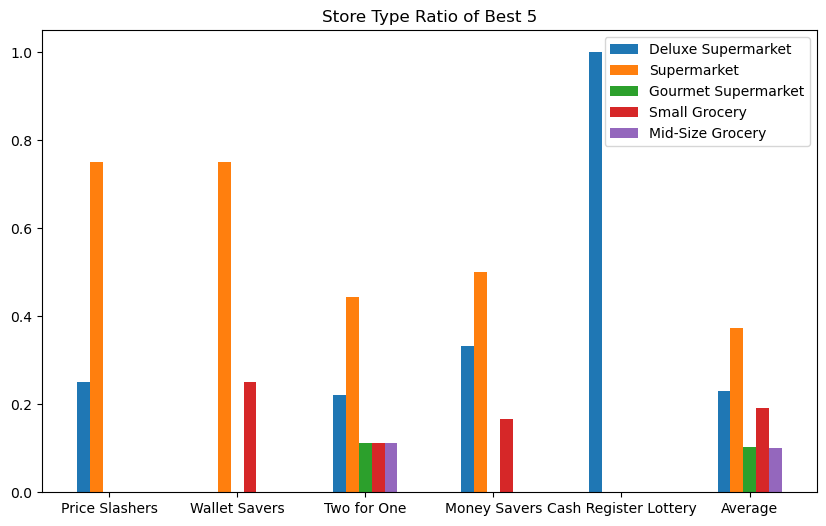

In [33]:
# 어떤 store에서 진행해야 고효율 프로모션인가
best5 = avg_cost_rank.head()['promotion_name'].values
best5 = np.append(best5, 'Average')

best_table = df[df['promotion_name'].isin(best5)][['promotion_name', 'store_id', 'cost', cate]].drop_duplicates()
avg_table = df[['promotion_name', 'store_id', 'cost', cate]].drop_duplicates()
avg_dict = avg_table[cate].value_counts().to_dict()
for i in range(len(category)): # store_type 별로 
    globals()['group{}'.format(i)] = [] 
    c = category[i] # Deluxe Supermarket
    for j in range(len(best5) - 1):  # best5, average ... Price Slashers
        tmp_dict = best_table[best_table['promotion_name'] == best5[j]][cate].value_counts().to_dict()
        total = promo_count[promo_count['promotion_name'] == best5[j]]['times'].iloc[0]
        times = tmp_dict.get(c)
        if times == None:
            times = 0
        rate = times/total
        globals()['group{}'.format(i)].append(rate)
    globals()['group{}'.format(i)].append(avg_dict.get(c)/avg_table.shape[0])

fig, ax = plt.subplots(figsize = (10, 6))

bar_width = 0.5/len(category)
index = np.arange(len(best5))
for k in range(len(category)):
    ax.bar(index, globals()['group{}'.format(k)], bar_width, label='{}'.format(category[k]))
    index = np.add(index, bar_width)

ax.set_title('Store Type Ratio of Best 5')
ax.set_xticks(index - bar_width*(len(category)//2 + 1))
ax.set_xticklabels(best5)
ax.legend()
plt.show()


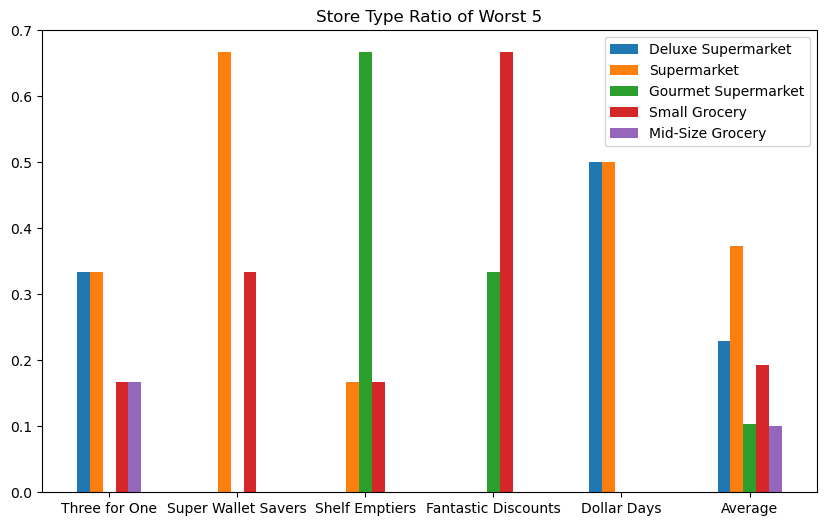

In [34]:
worst5 = avg_cost_rank.tail()['promotion_name'].values
worst5 = np.append(worst5, 'Average')

worst_table = df[df['promotion_name'].isin(worst5)][['promotion_name', 'store_id', 'cost', cate]].drop_duplicates()
avg_table = df[['promotion_name', 'store_id', 'cost', cate]].drop_duplicates()
avg_dict = avg_table[cate].value_counts().to_dict()
for i in range(len(category)): # store_type 별로 
    globals()['group{}'.format(i)] = [] 
    c = category[i] # Deluxe Supermarket
    for j in range(len(worst5) - 1):  # worst5, average ... Price Slashers
        tmp_dict = worst_table[worst_table['promotion_name'] == worst5[j]][cate].value_counts().to_dict()
        total = promo_count[promo_count['promotion_name'] == worst5[j]]['times'].iloc[0]
        times = tmp_dict.get(c)
        if times == None:
            times = 0
        rate = times/total
        globals()['group{}'.format(i)].append(rate)
    globals()['group{}'.format(i)].append(avg_dict.get(c)/avg_table.shape[0])

fig, ax = plt.subplots(figsize = (10, 6))

bar_width = 0.5/len(category)
index = np.arange(len(worst5))
for k in range(len(category)):
    ax.bar(index, globals()['group{}'.format(k)], bar_width, label='{}'.format(category[k]))
    index = np.add(index, bar_width)

ax.set_title('Store Type Ratio of Worst 5')
ax.set_xticks(index - bar_width*(len(category)//2 + 1))
ax.set_xticklabels(worst5)
ax.legend()
plt.show()


# 프로모션을 진행하는 곳의 Store Type은 아주 유의미 하지 않은 것 같다. 
    (진행한 store_type 비율이 비슷한 Wallet Savers, Super Wallet Savers   그런데 하나는 Best, 하나는 Worst )
    (별개로 Gourmet Supermarket, Grocery에서 프로모션을 많이 진행하면 효율이 좋지 않을수도 있을 것 같다 )
## State, Country, 지점 넓이, 타겟 성별, SRP등도 비교해봤는데 유의미하지 않은 것 같다.
## 내가 고객이라면 식품마트를 갈 때 가격이 싼 곳을 택할 것 같다.
## 그런데 데이터에선 판매가격은 주어지지 않는다(SRP만 주어짐)

In [35]:
table = pd.merge(avg_cost_rank, promo_count)
table.head()

,promotion_name,avg_cost,times
0,Price Slashers,69.192283,8
1,Wallet Savers,71.939836,4
2,Two for One,73.484200,9
3,Money Savers,73.720799,6
4,Cash Register Lottery,74.734129,4


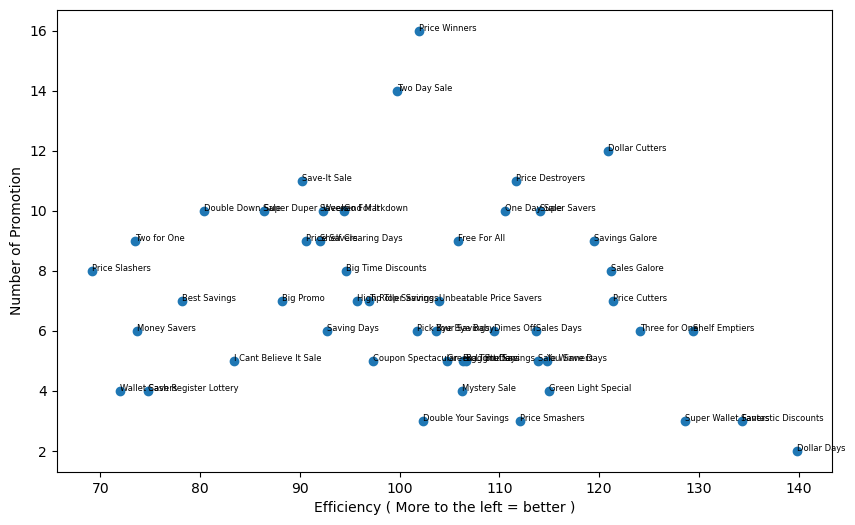

In [36]:
x = table['avg_cost']
y = table['times']
plt.figure(figsize=(10, 6))
plt.scatter(x, y)


for i, label in enumerate(table['promotion_name']):
    plt.annotate(label, (x[i], y[i]), fontsize=6)

plt.xlabel('Efficiency ( More to the left = better )')    
plt.ylabel('Number of Promotion')

plt.show()

In [37]:
np.corrcoef(x, y) # 아주 약한 음의 상관관계, 반응이 좋은 프로모션일수록 많이 진행했을것이니 음의 상관관계가 이해는 된다.

array([[ 1.        , -0.21257266],
       [-0.21257266,  1.        ]])

### 프로모션의 효율성을 따지려면 프로모션의 내용에 대한 더 자세한 정보(할인율, 시기 등)가 더 필요할 것 같다.

# 4. coffee_bar가 있는 shop과 아닌 shop의 매출 고객수를 비교하시오.

In [38]:
yes_coffee = []
no_coffee = []

for i in range(len(df['store_id'].unique())):
    is_coffee = df[df['store_id'] == i]['coffee_bar'].iloc[0]
    if is_coffee:
        yes_coffee.append(i)
    else:
        no_coffee.append(i)

yes_coffee, no_coffee # shop_id

([0, 1, 2, 5, 7, 9, 11, 13, 15, 16, 18, 19], [3, 4, 6, 8, 10, 12, 14, 17])

In [39]:
df[df['store_id'].isin(yes_coffee)].count().iloc[0] / len(yes_coffee) # 커피샵있는 지점 평균 매출고객 수

3085.0833333333335

In [40]:
df[df['store_id'].isin(no_coffee)].count().iloc[0] / len(yes_coffee) # 커피샵없는 지점 평균 매출고객 수

1950.5833333333333

In [41]:
df[df['store_id'].isin(yes_coffee)][['store_id','store_type']].drop_duplicates()

,store_id,store_type
0,0,Deluxe Supermarket
18,1,Deluxe Supermarket
40,2,Supermarket
82,5,Gourmet Supermarket
110,7,Small Grocery
119,9,Deluxe Supermarket
139,11,Deluxe Supermarket
156,13,Deluxe Supermarket
187,15,Gourmet Supermarket
189,16,Small Grocery


In [42]:
df[df['store_id'].isin(no_coffee)][['store_id','store_type']].drop_duplicates()

,store_id,store_type
58,3,Supermarket
73,4,Supermarket
100,6,Supermarket
113,8,Supermarket
136,10,Mid-Size Grocery
152,12,Mid-Size Grocery
174,14,Supermarket
191,17,Supermarket


#### 커피샵이 있는 매장에 고객이 더 많지만, 다른 문제에서  확인해보니까 Deluxe, Gourmet Supermarket의 영향인것 같다. (Grocery 매장의 고객수는 매우 적은편)

# 5. prepared_food 가 있는 shop과 아닌 shop의 매출 고객수를 비교하시오.

In [43]:
yes_pf = [] # pf = prepared food
no_pf = []

for i in range(len(df['store_id'].unique())):
    is_pf = df[df['store_id'] == i]['prepared_food'].iloc[0]
    if is_pf:
        yes_pf.append(i)
    else:
        no_pf.append(i)

yes_pf, no_pf # shop_id

([0, 1, 5, 8, 9, 11, 13, 14, 15], [2, 3, 4, 6, 7, 10, 12, 16, 17, 18, 19])

In [44]:
df[df['store_id'].isin(yes_pf)].count().iloc[0] / len(yes_pf) # pf있는 지점 평균 매출고객 수

3947.6666666666665

In [45]:
df[df['store_id'].isin(no_pf)].count().iloc[0] / len(yes_pf) # pf없는 지점 평균 매출고객 수

2766.5555555555557

In [46]:
df[df['store_id'].isin(yes_pf)][['store_id','store_type']].drop_duplicates()

,store_id,store_type
0,0,Deluxe Supermarket
18,1,Deluxe Supermarket
82,5,Gourmet Supermarket
113,8,Supermarket
119,9,Deluxe Supermarket
139,11,Deluxe Supermarket
156,13,Deluxe Supermarket
174,14,Supermarket
187,15,Gourmet Supermarket


In [47]:
df[df['store_id'].isin(no_pf)][['store_id','store_type']].drop_duplicates()

,store_id,store_type
40,2,Supermarket
58,3,Supermarket
73,4,Supermarket
100,6,Supermarket
110,7,Small Grocery
136,10,Mid-Size Grocery
152,12,Mid-Size Grocery
189,16,Small Grocery
191,17,Supermarket
193,18,Small Grocery


### Deluxe, Gourmet 같은 고급화 매장에 pf가 많다. 
#### Prepared_food가 있어서 고객이 많다기 보다는, 고급화 매장이라 고객이 많고, Prepared_food도 있는 것 같다.
#### 중소형 사이즈의 매장에는 pf가 없다. (small, mid-size --> 고객도 적음)

# 6. 샵 크기와 고객수의 관계를 분석하시오

In [48]:
# 아까 store_id와 store_sqft는 1대1 대응임을 확인 했음
sqft_cust = dfsql('''
                    select store_id, min(store_sqft) as sqft, count(*) as num_of_cust from df 
                    group by store_id order by store_id
                    ''') #min, max, avg 모두 똑같이 나온다. 

In [49]:
sqft_cust.head()

,store_id,sqft,num_of_cust
0,0,27694.0,5478
1,1,33858.0,5704
2,2,21215.0,5051
3,3,30268.0,4453
4,4,23598.0,3960


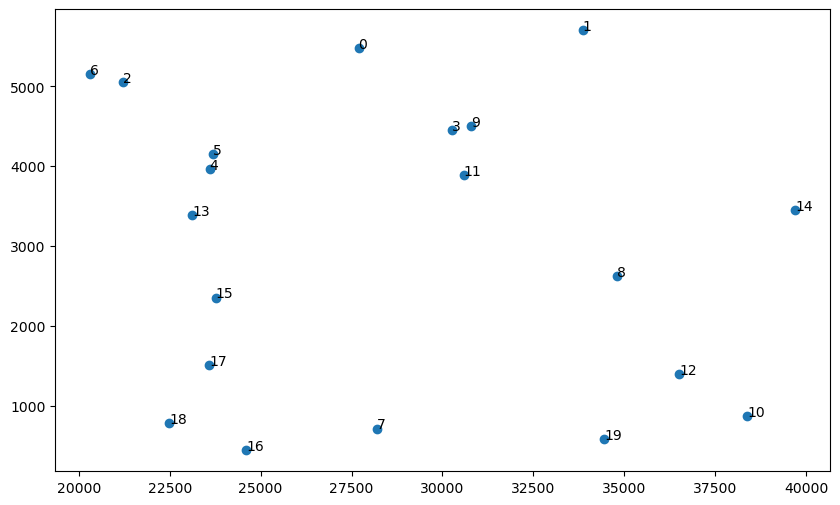

In [50]:
x = sqft_cust['sqft']
y = sqft_cust['num_of_cust']
plt.figure(figsize=(10, 6))
plt.scatter(x, y)

for i, label in enumerate(sqft_cust['store_id']):
    plt.annotate(label, (x[i], y[i]), fontsize=10)

In [51]:
np.corrcoef(x, y) # 예상 외로 음의 상관관계를 보인다.
                    # 미국은 땅이 커서 그런가?

array([[ 1.        , -0.17103207],
       [-0.17103207,  1.        ]])

In [52]:
tmp = df[['store_id', 'store_type']].drop_duplicates()

In [53]:
sqft_type = pd.merge(sqft_cust, tmp)
sqft_type.head()

,store_id,sqft,num_of_cust,store_type
0,0,27694.0,5478,Deluxe Supermarket
1,1,33858.0,5704,Deluxe Supermarket
2,2,21215.0,5051,Supermarket
3,3,30268.0,4453,Supermarket
4,4,23598.0,3960,Supermarket


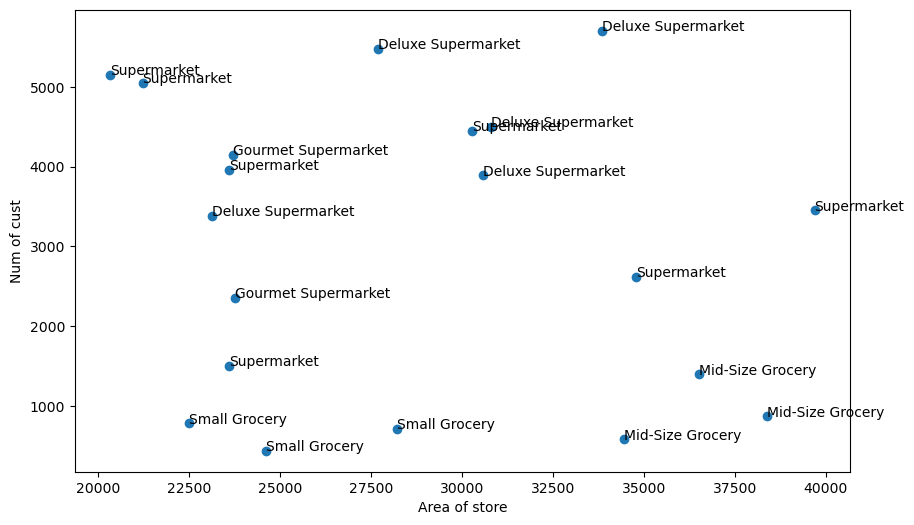

In [54]:
x = sqft_type['sqft']
y = sqft_type['num_of_cust']
plt.figure(figsize=(10, 6))
plt.scatter(x, y)

plt.xlabel('Area of store')
plt.ylabel('Num of cust')
for i, label in enumerate(sqft_type['store_type']):
    plt.annotate(label, (x[i], y[i]), fontsize=10)
    
plt.show()

#### 고객수는 매장의 넓이보단 매장의 형태 (Grocery, Supermarket)에서 고객수의 차이가 나타난다.

# 7. 여성이 커피바가 있는 숍에 더 반응하는가?

In [55]:
coffee_gender = df['gender'].value_counts().to_dict()
coffee_gender

{'F': 30942, 'M': 29486}

In [56]:
f_rates = df.loc[df['gender'] == 'F']['coffee_bar'].sum() / coffee_gender.get('F')
m_rates = df.loc[df['gender'] == 'M']['coffee_bar'].sum() / coffee_gender.get('M')

print(f'Coffee bar rate of Total Female reaction : {f_rates}')
print(f'Coffee bar rate of Total Male reaction : {m_rates}') 

Coffee bar rate of Total Female reaction : 0.6268825544567255
Coffee bar rate of Total Male reaction : 0.5977073865563318


### 아주 조금 차이 난다.

# 8. 여성이 꽃집이 있는 숍에 더 반응하는가?

In [57]:
f_rates = df.loc[df['gender'] == 'F']['florist'].sum() / coffee_gender.get('F')
m_rates = df.loc[df['gender'] == 'M']['florist'].sum() / coffee_gender.get('M')

print(f'Flower shop rate of Total Female reaction : {f_rates}')
print(f'Flower shop rate of Total Male reaction : {m_rates}') 

Flower shop rate of Total Female reaction : 0.5670286342188611
Flower shop rate of Total Male reaction : 0.5579597096927356


### 거의 차이나지 않는다. (애초에 식료품점에 꽃을 사러가는게 이상한 소리로 들린다..)

In [58]:
df[['store_id', 'florist']].drop_duplicates()['florist'].sum() # 꽃집이 많다 그래도

9.0

# 9. Shop 단위로 프로모션 결과를 분석하시오.

In [59]:
branch_list = df['store_id'].unique()

branches = []
for i in range(len(branch_list)):
    globals()['branch{}'.format(i)] = df[df['store_id'] == branch_list[i]]
    branches.append(globals()['branch{}'.format(i)])

In [62]:
branch_dfs = []
for i in range(len(branches)):
    globals()['branch_df{}'.format(i)] = dfsql(f''' 
    select promotion_name, count(*) as num_of_cust, round(sum(cost)/count(*), 2) as avg_cost, count(distinct cost) as times
    from branch{i} 
    group by promotion_name order by avg_cost
    ''')
    
    branch_dfs.append(globals()['branch_df{}'.format(i)])
len(branch_dfs) # 20

20

In [63]:
def get_branch_df(i):
    branch_num = df['store_id'].unique()[i]
    print(f'Promotion result of Branch{branch_num}')
    display(branch_dfs[i])

get_branch_df(19)

Promotion result of Branch19


,promotion_name,num_of_cust,avg_cost,times
0,Shelf Clearing Days,50,51.16,1
1,I Cant Believe It Sale,72,52.77,1
2,Save-It Sale,128,68.51,2
3,Super Duper Savers,62,87.76,1
4,Double Your Savings,47,114.72,1
5,Savings Galore,95,130.06,1
6,Sales Days,58,132.88,1
7,Green Light Special,68,147.17,1
